#### 1. ADMM preliminaries

1a. Transform $ \min\limits_{x} \space \delta_C(x) + \delta_D(x) $ into 2-block separable structure that ADMM can handle.

We rewrite the objective function as: <br>
<br>
$ \min\limits_{x,y} \space \delta_C(x) + \delta_D(y) $ s.t. $ x = y $ <br>
with constraint: $Ax + By = c$, where $A = I$, $B = -1$, and $c = 0$ <br>
<br>

1b. We derive the explicit formulae of the ADMM iterations via the lagrangian form: <br>
<br>
$ L_{\sigma}(x, y, u) = \min\limits_{x,y} \space \delta_C(x) + \delta_D(y) + \langle u, x-y \rangle + \frac{\sigma}{2} \|x-y+u\|^2$, <br>
where $u$ is the lagrangian multiplier <br>
<br>
We yield the following for the ADMM iterations:<br>
$x^{(k+1)} = \Pi_{C}(y^{(k)} + \sigma^{-1}u^{(k)})$ <br>
$y^{(k+1)} = \Pi_{D}(x^{(k+1)} + \sigma^{-1}u^{(k)})$ <br> 
$u^{(k+1)} = u^{(k)} + \tau\sigma(x^{(k+1)} - y^{(k+1)})$ <br>
<br>


1c. Starting with $\sigma = 1$, $\tau = 1$, $C = [1,2] \subseteq \mathbb{R}$, $D = [1.5,3] \subseteq \mathbb{R}$, <br>
and initializing every variable with zero, i.e. $x^{(0)} = y^{(0)} = u^{(0)} = 0$, <br>
we compute the first two iterations of ADMM: <br>
<br>

First iteration, i.e. $ k = 0 $:<br>
$x^{(1)} = \Pi_{C}(y^{(0)} + \sigma^{-1}u^{(0)}) = \Pi_{C}(0) = 1 $ <br>
$y^{(1)} = \Pi_{D}(x^{(1)} + \sigma^{-1}u^{(0)}) = \Pi_{D}(1) = 1.5$ <br> 
$u^{(1)} = u^{(0)} + (1)(1)(x^{(1)} - y^{(1)}) = 0 + (1 - 1.5) = -0.5$ <br>
<br>

Second iteration, i.e. $ k = 1 $: <br>
$x^{(2)} = \Pi_{C}(y^{(1)} + u^{(1)}) = \Pi_{C}(0.5 + 0) = 1$ <br>
$y^{(2)} = \Pi_{D}(x^{(2)} + u^{(1)}) = \Pi_{D}(1 + 0) = 1.5$ <br> 
$u^{(2)} = u^{(1)} + (x^{(2)} - y^{(2)}) = -0.5 + (1-1.5) = -1$ <br>
    

#### 2. Robust PCA

$\min\limits_{L,S} \space \| L \|_* + \lambda\| S \|_1 $ s.t. $ L + S = M $


2a. ADMM for robust PCA

In [1]:
# libraries needed
import time
import pandas as pd
import numpy as np
import scipy as sp
from scipy.sparse import random
import cv2
import matplotlib.pyplot as plt

In [2]:
# define functions for stopping condition and soft-thresholding

def residual_Xk(Xk, Xk_):
    """
    Calculate the "forbenius norm" term
    
    Xk: np.array matrix Lk or Sk; ie at step k
    Xk_: np.array matrix L(k-1) or S(k-1); ie at step k-1
    
    :return: float()
    """
        
    return (np.linalg.norm(Xk - Xk_, ord = "fro"))/(1 + np.linalg.norm(Xk, ord = "fro"))


def residual_rk(Lk, Lk_, Sk, Sk_):
    """        
    Calculate r^(k), the residual term at step k
    
    inputs are np.arrays (ie matrices)
        Lk: L at step k
        Lk_: L at step k
        Sk: S at step k
        Sk_: S at step k-1
    
    :returns float():
    """
    return max(residual_Xk(Lk, Lk_), residual_Xk(Sk, Sk_))

def soft_threshold(beta, lambda_):
    """
    Perform soft-thresholding of beta
    
    beta: float() inpput to soft-thresholding function
    lambda_: float() lambda penalty term 
    
    :returns: float()
    """
    return np.sign(beta)*np.maximum(np.abs(beta)-lambda_, np.zeros(beta.shape))


In [3]:
def admm(M, rho, tau, lambda_):
    """
    Perform ADMM for robust PCA
    
    M: numpy matrix to perform ADMM on
    rho: float() rho parameter
    tau: float() tau paramter
    :return: 
        Lk: numpy matrix (low rank) that is decomposed from ADMM
        Sk: numpy matrix (sparse) that is decomposed from ADMM
    """
   
    # initialize
    m, n = M.shape
    Sk_ = np.zeros((m, n))
    Zk_ = np.zeros((m, n))
    iter_res = [] # to store iteration number and residual

    
    # perform reduced SVD
    _, D, _ = np.linalg.svd(M, full_matrices=False)
    sigma = 1/max(D)
    res = 1
    
    for iteration in range(200):
        # set the new paramters to old parameters after the first step
        if iteration > 0:
            Lk_ = Lk 
            Sk_ = Sk
            Zk_ = Zk
        
        # step 1: subproblem L
#         T_k0 = M - Sk_ - (1/sigma)*Zk_
        Tk_ = M - Sk_ - (1/sigma)*Zk_
        # perform reduced SVD
        U, D, V_T = np.linalg.svd(Tk_, full_matrices=False)
        
        # perform soft thresholding
        D = soft_threshold(D, 1/sigma)
        D = np.diag(D)
        Lk = np.dot(U, np.dot(D, V_T))
        
        # step 2: subproblem S
        beta_temp = M - Lk - (1/sigma)*Zk_
        Sk = soft_threshold(beta_temp, lambda_/sigma)
        
        # step 3: subproblem Z
        Zk = Zk_ + tau*sigma*(Lk + Sk - M)
        
        # calculate residual
        # iteration needs to be at least after 1 step so that Lk_ exists
        if iteration > 1:
            res = residual_rk(Lk, Lk_, Sk, Sk_)
        
        iter_res.append([iteration+1, res])
        
        # check convergence criteria
        if res < 1e-4:
            break
        
        sigma *= rho
        
    # create dataframe with iteration and residual values
    df = pd.DataFrame(iter_res, columns=['Iteration', 'Residual'])
    
    # plot residual values
    plt.plot(df['Iteration'], df['Residual'])
    plt.xlabel('Iteration')
    plt.ylabel('Residual')
    plt.title('Convergence of ADMM for Robust PCA')
    plt.show()
        
    return Lk, Sk, df


In [4]:
m, n = 500, 1000
W = np.random.standard_normal(size=(m, 10))
H = np.random.standard_normal(size=(10, n))
L0 = W @ H
# create sparse array and convert to numpy
S0 = random(m, n, density=0.05).toarray()
M = L0 + S0

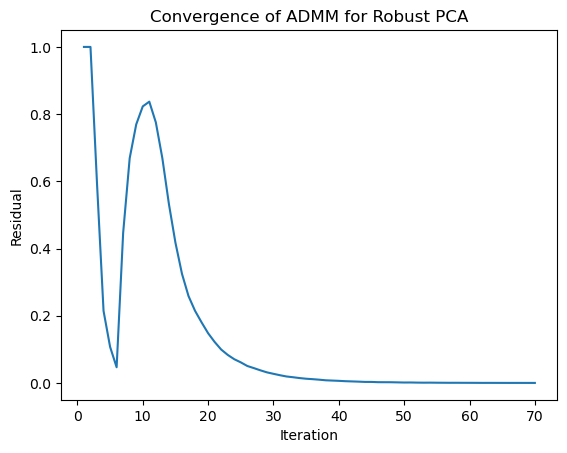

time taken for 70 iterations = 84.47 cpu seconds = 23.78 clock seconds using reduced svd


In [5]:
# set initial values
m,n = M.shape
lambda_ = 1/(max(m, n)**0.5)
rho = 1.1
tau = 1.5

# run admm for matrix M
start_cpu, start_clock = time.process_time(), time.time()

L, S, df = admm(M, rho, tau, lambda_)

time_taken_cpu, time_taken_clock = time.process_time() - start_cpu, time.time() - start_clock

# print stats for algorithm
print(f"time taken for {df['Iteration'].iloc[-1]} \
iterations = {time_taken_cpu:.2f} cpu seconds \
= {time_taken_clock:.2f} clock seconds using reduced svd")

compute $\|L-L_0\|_F$ and $\|S-S_0\|_F$
* $\|L-L_0\|_F = 3.53 \times 10^{-3}$ 
* $\|S-S_0\|_F = 1.19 \times 10^{-2}$


In [6]:
L_truth = np.linalg.norm(L - L0, ord = "fro")
S_truth = np.linalg.norm(S - S0, ord = "fro")
L_truth, S_truth

(0.003539515511371208, 0.011948342086029122)

2c. Apply admm to Basketball player video

In [7]:
# load video as np array
video = pd.read_csv("BasketballPlayer.csv", header=None).to_numpy()
# check shape of video; should be (1261332, 112)
video.shape == (1261332, 112)

True

Report the number of iteration, running time, the term r(k) defined above, the rank of your estimated matrix L, and the number of non-zero entries in your estimated matrix S.
* number of iterations, $k = 70$
* $r^{(k)} = 8.6 \times 10^{-5}$
* rank of estimated matrix $L = 45$
* number of non-zero entries in estimated matrix $S = 1.33 \times 10^{8}$

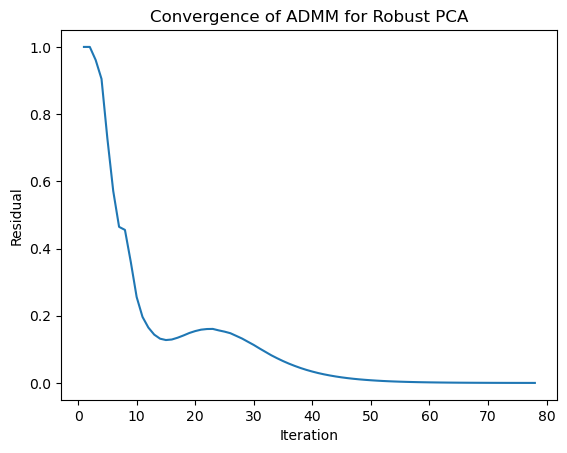

time taken for 70 iterations = 4630.37 cpu seconds = 911.84 clock seconds


In [9]:
# set initial values
m,n = video.shape
lambda_ = 1/(max(m, n)**0.5)
rho = 1.1
tau = 1.5

start_cpu, start_clock = time.process_time(), time.time()

L_video, S_video, df_video = admm(video, rho, tau, lambda_)

time_taken_cpu, time_taken_clock = time.process_time() - start_cpu, time.time() - start_clock

print(f"time taken for {df['Iteration'].iloc[-1]} \
iterations = {time_taken_cpu:.2f} cpu seconds \
= {time_taken_clock:.2f} clock seconds")

In [10]:
df_video.tail(1)

,Iteration,Residual
77,78,0.000086


In [11]:
print(f"time taken for {df['Iteration'].iloc[-1]} \
iterations = {time_taken_cpu:.2f} cpu seconds \
= {time_taken_clock:.2f} clock seconds")
print("The rank of estimated matrix L_video is:", np.linalg.matrix_rank(L_video))
print("Number of nonzero entries in S_video =", np.count_nonzero(S_video))

time taken for 70 iterations = 4630.37 cpu seconds = 911.84 clock seconds
The rank of estimated matrix L_video is: 45
Number of nonzero entries in S_video = 133177213


In [12]:
video.shape

(1261332, 112)

In [13]:
video.shape == L_video.shape ==S_video.shape

True

In [14]:
def min_max_scaler(x):
    """
    Perform min-max scaling on input array

    x: np.array to transform
    
    :return:
    np.array that is scaled
    """
    
    x_min = np.min(x)
    x_max = np.max(x)
    x = (x - x_min)/(x_max - x_min)
    return x

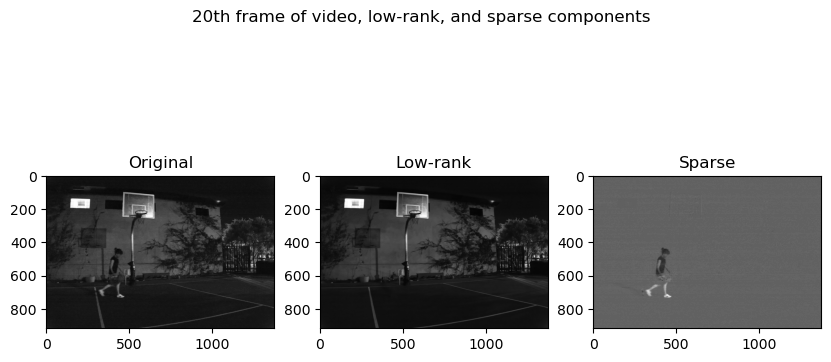

In [15]:
import matplotlib.pyplot as plt

# Create figure with 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

# Plot original image
video20 = video[:,19].reshape(1374, 918).T
axs[0].imshow(video20, cmap="gray")
axs[0].set_title("Original")

# Plot low-rank image
L20 = min_max_scaler(L_video)[:,19].reshape(1374, 918).T
axs[1].imshow(L20, cmap="gray")
axs[1].set_title("Low-rank")

# Plot sparse image
S20 = min_max_scaler(S_video)[:,19].reshape(1374, 918).T
axs[2].imshow(S20, cmap="gray")
axs[2].set_title("Sparse")

# Set common title for the figure
fig.suptitle("20th frame of video, low-rank, and sparse components")

# Display the plot
plt.show()


2e. Visualize L and S by making a background video and a moving object video.

In [16]:
def matrix_to_video(video, filename):
    """
    Convert a np.array (matrix) to a video file with dimensions (918, 1374)
    
    video: np.ndarray matrix containing video frames of shape (1261332, 112)
    filename (str): name of the output video file (e.g. 'L_video.mov')
    
    :return: None; function "releases" the file directly into working directoy
    """
    
    # create a video writer object with specified filename and properties
    # fps = 11 to create s shorter (faster) video
    video_temp = cv2.VideoWriter(filename, cv2.VideoWriter_fourcc(*'avc1'), 11, (1374,918), False)
    
    # loop through each frame in the input matrix
    for idx in range(video.shape[1]):
        
        # extract the frame and perform min-max scaling
        frame = (min_max_scaler(video[:,idx].reshape(1374, 918).T)*255).astype("uint8")
        # write the frame to the video file
        video_temp.write(frame)
        
    # release the video writer object and close all windows
    cv2.destroyAllWindows()
    video_temp.release()

In [17]:
matrix_to_video(S_video, 'S_video.mov')
matrix_to_video(L_video, 'L_video.mov')